# Data Explore

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from networkx.algorithms import community

## Cleaned Data Import

In [2]:
df_track = pd.read_csv('data/track.csv')
df_album = pd.read_csv('data/album.csv')
df_artist = pd.read_csv('data/artist.csv')
df_rating = pd.read_csv('data/rating.csv')
df_similar = pd.read_csv('data/track_similarity.csv')
df_weekly_rating = pd.read_csv('data/weekly_rating.csv')

## Defining Useful functions

In [3]:
# ======================= Convert Names to IDs =============================

def convert_artist_name_to_id(df_artist, artist_name):
    return df_artist[df_artist['name'] == artist_name]['artist_id'].values[0]

def convert_album_name_to_id(album_name):
    return df_album[df_album['name'] == album_name]['album_id'].values[0]

def convert_track_name_to_id(track_name):
    return df_track[df_track['name'] == track_name]['track_id'].values[0]

# ======================= Convert Ids to Names =============================

def convert_track_id_to_name(track_id):
    return df_track[df_track['track_id'] == track_id]['name'].values[0]

def convert_album_id_to_name(album_id):
    return df_album[df_album['album_id'] == album_id]['name'].values[0]

def convert_artist_id_to_name(artist_id):
    return df_artist[df_artist['artist_id'] == artist_id]['name'].values[0]

# ======================= Others =============================

def get_all_artist_albums(artist_name, byName=False):
    all_albums = df_artist[df_artist['name'] == artist_name]['all_albums'].values[0]
    all_albums = all_albums[1:-1].split(',')
    all_albums = [int(album) for album in all_albums]

    if byName:
        all_albums = [convert_album_id_to_name(album) for album in all_albums]

    return all_albums

def get_all_artist_tracks(artist_name, byName=False):
    all_tracks = df_artist[df_artist['name'] == artist_name]['all_tracks'].values[0]
    all_tracks = all_tracks[1:-1].split(',')
    all_tracks = [int(track) for track in all_tracks]

    all_tracks = [convert_track_id_to_name(track) for track in all_tracks]

    return all_tracks

## Exploration

In [4]:
# number of different artists
artist_count = len(df_artist)
print("Number of different artists:", artist_count) 

# number of different albums
album_count = len(df_album)
print("Number of different albums:", album_count)

# number of different tracks
track_count = len(df_track)
print("Number of different tracks:", track_count)

# mean number of tracks per album
mean_tracks_per_album = round(track_count / album_count, 1)
print("\nMean number of tracks per album:", mean_tracks_per_album)

# mean number of albums per artist
mean_albums_per_artist = round(album_count / artist_count, 1)   
print("Mean number of albums per artist:", mean_albums_per_artist)

# mean number of tracks per artist
mean_tracks_per_artist = round(track_count / artist_count, 1)
print("Mean number of tracks per artist:", mean_tracks_per_artist)

Number of different artists: 2557
Number of different albums: 1843
Number of different tracks: 23385

Mean number of tracks per album: 12.7
Mean number of albums per artist: 0.7
Mean number of tracks per artist: 9.1


In [15]:
# how many artists without any album
artists_without_album = len(df_artist[df_artist['all_albums'] == '[]'])
print("\nNumber of artists without any album:", artists_without_album)
# percentage of artists without any album
percentage_artists_without_album = round(artists_without_album / artist_count * 100, 1)
print("Percentage of artists without any album:", percentage_artists_without_album, "%")


Number of artists without any album: 1620
Percentage of artists without any album: 63.4 %


### Artists

In [5]:
# Filter rows containing 'bieber', handling NaN values
bieber_artists = df_artist[df_artist['name'].str.contains('bieber', na=False, case=False)]

# Display the results
print('Artists containing "Bieber":\n', bieber_artists["name"])
print('Number of artists containing "Bieber":', len(bieber_artists))

Artists containing "Bieber":
 330        Justin Bieber Featuring Chance The Rapper
342                                    Justin Bieber
357     Maejor Ali Featuring Juicy J & Justin Bieber
378                 Justin Bieber Featuring R. Kelly
400                             Tyga & Justin Bieber
479                will.i.am Featuring Justin Bieber
522                 Justin Bieber Featuring Ludacris
539              Justin Bieber Featuring Nicki Minaj
581                 Justin Bieber Featuring Big Sean
628         Carly Rae Jepsen Featuring Justin Bieber
673                    Justin Bieber Featuring Drake
732        Far*East Movement Featuring Justin Bieber
772             Justin Bieber Featuring Busta Rhymes
796             Justin Bieber Duet With Mariah Carey
798                    Justin Bieber Featuring Usher
881              Chris Brown Featuring Justin Bieber
921              Justin Bieber Featuring Jaden Smith
1062                   Sean Kingston & Justin Bieber
Name: name, dtyp

In [11]:
# how many of the artist have either "&" or "and" or "featuring" in their name

# Filter rows containing '&', 'and' or 'featuring', handling NaN values
and_artists = df_artist[df_artist['name'].str.contains('&|featuring|and', na=False)]

# Display the results

print('Artists containing "&", "and" or "featuring":\n', and_artists["name"])
print('Number of artists containing "&", "and" or "featuring":', len(and_artists["name"]))

Artists containing "&", "and" or "featuring":
 7                              Ariana Grande & The Weeknd
13      Nicki Minaj Featuring Drake, Lil Wayne & Chris...
21                  Jessie J, Ariana Grande & Nicki Minaj
29                                        Pitbull & Ne-Yo
34                                     Chris Brown & Tyga
                              ...                        
2445                                       Future Islands
2450                                         Clean Bandit
2458                                    RÃ¶yksopp & Robyn
2510                                         Judy Garland
2521                               Lilly Wood & The Prick
Name: name, Length: 464, dtype: object
Number of artists containing "&", "and" or "featuring": 464


In [12]:
# number of different track_ids in the track_similarity 
# table because there are duplicates
unique_track_ids = df_similar[['track_id_1', 'track_id_2']].stack().unique()
print('Number of unique track_ids in the track_similarity table:', len(unique_track_ids))

Number of unique track_ids in the track_similarity table: 7211


### Tracks & Albums

In [7]:
# get all tracks of an artist
artist_name = 'Taylor Swift'

# get all albums of an artist
all_albums = get_all_artist_albums(artist_name, byName=True)
all_tracks = get_all_artist_tracks(artist_name, byName=True)

print(f"\nAlbums by {artist_name}:")
for album in all_albums:
    print(album)

print(f"\n====================\nTracks by {artist_name}:")
for track in all_tracks:
    print(track)


Albums by Taylor Swift:
1989
Shake It Off
We Are Never Ever Getting Back Together
Red Karaoke
Ronan
The Hunger Games: Songs from District 12 and Beyond
Today Was a Fairytale
Taylor Swift
iTunes Live from SoHo

Tracks by Taylor Swift:
Blank Space
Shake It Off
Style
Bad Blood
Welcome To New York
Wildest Dreams
Out Of The Woods
Red
Sweeter Than Fiction
22
I Knew You Were Trouble.
Begin Again
We Are Never Ever Getting Back Together
The Moment I Knew
I Almost Do
All Too Well
Stay Stay Stay
State Of Grace
Ronan
Eyes Open
Ours
Sparks Fly
If This Was A Movie
Superman
Haunted
Mean
The Story Of Us
Back To December
Mine
Innocent
Dear John
Better Than Revenge
Last Kiss
Enchanted
Never Grow Up
Long Live
Speak Now
Today Was A Fairytale
Fearless
You Belong With Me
Breathless
Fifteen
Jump Then Fall
Untouchable
The Other Side Of The Door
Forever & Always
Superstar
Come In With The Rain
Love Story
Crazier
White Horse
You're Not Sorry
The Way I Loved You
Breathe
Hey Stephen
Should've Said No
Change
Pict

Top 20 artists by number of tracks:
      artist_id  track_count            artist_name
407         408          358              Glee Cast
358         359          130             Kanye West
342         343          130          Justin Bieber
2322       2323          126         The Beach Boys
2331       2332          126         Cloud Nothings
657         658          124                   T.I.
2191       2192          120            The Beatles
150         151          114               Coldplay
2101       2102          112           Beastie Boys
1187       1188          111                 Weezer
186         187          109          Calvin Harris
2491       2492          109             Aphex Twin
226         227          107          George Strait
1683       1684          100        Nine Inch Nails
1633       1634          100  The Smashing Pumpkins
122         123          100                  Drake
370         371           96                Rihanna
51           52           96

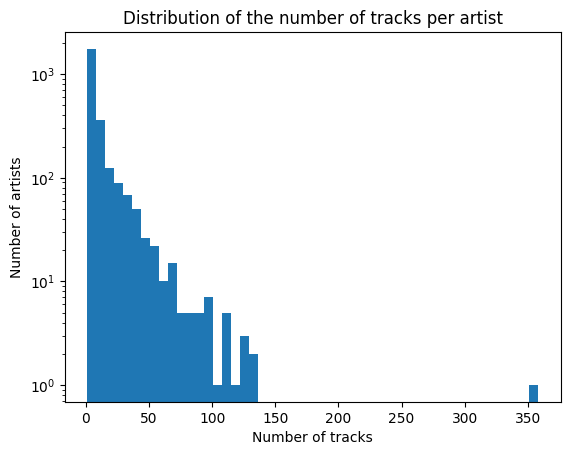

In [16]:
# print the 20 artists with the most tracks
artist_track_count = df_track.groupby('artist_id').size().reset_index(name='track_count')
artist_track_count = artist_track_count.sort_values(by='track_count', ascending=False)

# make a distribution of the number of tracks per artist
plt.hist(artist_track_count['track_count'], bins=50)
plt.xlabel('Number of tracks')
plt.ylabel('Number of artists')
plt.yscale('log')
plt.title('Distribution of the number of tracks per artist')

artist_track_count = artist_track_count.head(20)
artist_track_count['artist_name'] = artist_track_count['artist_id'].apply(convert_artist_id_to_name)
print("Top 20 artists by number of tracks:\n" + str(artist_track_count))

# print the median track count per artist
median_track_count = artist_track_count['track_count'].median()
print(f"\nMedian track count per artist: {median_track_count}")

Top 20 albums by number of tracks:
      album_id  track_count                                       album_name
446      448.0          130         Glee: The Music, The Complete Season Two
1504    1506.0          115  Good Vibrations: Thirty Years of The Beach Boys
1520    1522.0          112                              BIRP! February 2012
270      272.0          106        Glee: The Music, The Complete Season Four
1785    1787.0           95                Bleep: The Top 100 Tracks of 2014
175      177.0           87            Musikvideos Jahrescharts 2013 Top 100
1054    1056.0           85                          Disney Classics Box Set
312      314.0           82                                 100x Liefde 2014
599      601.0           62                                    Årsbeste 2009
177      179.0           61                        The Disco Boys, Volume 14
291      293.0           58                          The Video Year Mix 2012
1839    1841.0           54              

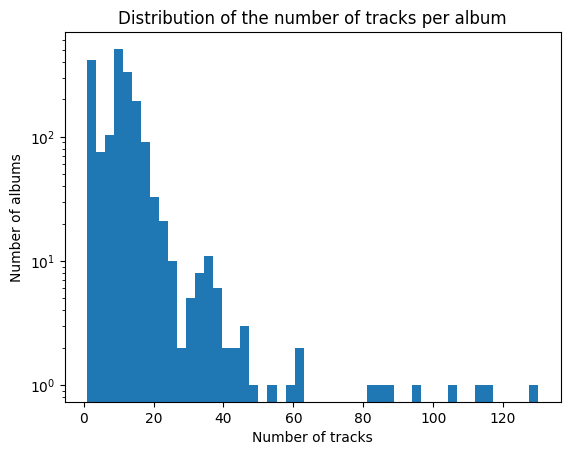

In [9]:
# number of tracks per album
album_track_count = df_track.groupby('album_id').size().reset_index(name='track_count')
album_track_count = album_track_count.sort_values(by='track_count', ascending=False)

# make a distribution of the number of tracks per album
plt.hist(album_track_count['track_count'], bins=50)
plt.xlabel('Number of tracks')
plt.ylabel('Number of albums')
plt.yscale('log')
plt.title('Distribution of the number of tracks per album')

album_track_count = album_track_count.head(20)
album_track_count['album_name'] = album_track_count['album_id'].apply(convert_album_id_to_name)
print("Top 20 albums by number of tracks:\n" + str(album_track_count))

## 1 Year Analysis
In order to be able to consider data from all three sources, we will analyze the interval between 01/05/2013 and 01/05/2014. For epoch analysis between 29/04/2013 and 04/05/2014, which means weeks 487 to 539

In [10]:
# Get the year dataframe, which is from weekly_rating, get all rows that have time_epoch >= 487 and time_epoch <= 539
df_year = df_weekly_rating[(df_weekly_rating['time_epoch'] >= 487) & (df_weekly_rating['time_epoch'] <= 539)]
df_year.shape

(10931, 7)

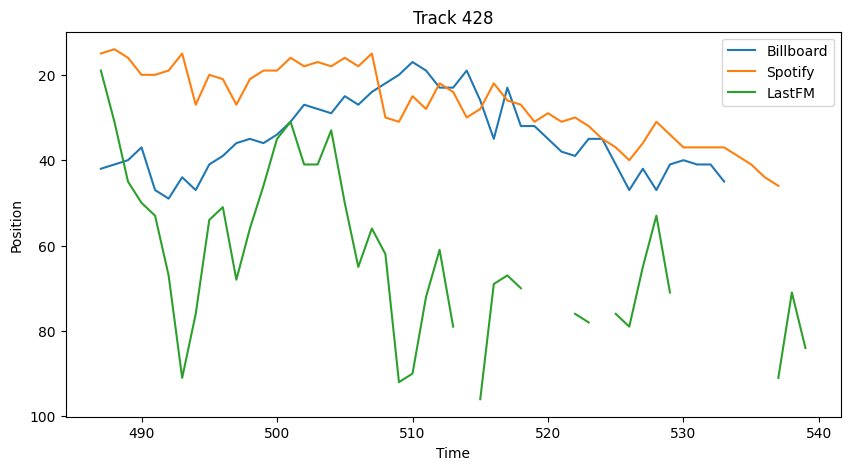

In [11]:
# From the yearly dataframe, lets analyze first a single track, id 428
df_year_single = df_year[df_year['track_id'] == 428]
df_year_single.shape

# Plot the track rating over the year, need three lines, one for position_billboard, other for position_spotify and other for position_lastfm, invert the y axis to show the rating from 1 to 100
plt.figure(figsize=(10, 5))
plt.plot(df_year_single['time_epoch'], df_year_single['position_billboard'], label='Billboard')
plt.plot(df_year_single['time_epoch'], df_year_single['position_spotify'], label='Spotify')
plt.plot(df_year_single['time_epoch'], df_year_single['position_lastfm'], label='LastFM')
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Track 428')
plt.gca().invert_yaxis()
plt.legend()
plt.show()

In [12]:
# Detect which track has the highest correlation between the three positions, using spearman correlation, and only using rows where both positions are not NaN
# Get the track ids
track_ids = df_year['track_id'].unique()

# Create a list to store the correlations
correlations = []

# Iterate over the track ids
for track_id in track_ids:
    # Get the track data
    df_year_single = df_year[df_year['track_id'] == track_id]
    billboard_spotify_filtered = df_year_single.dropna(subset=['position_billboard','position_spotify'],how='any')
    billboard_lastfm_filtered = df_year_single.dropna(subset=['position_billboard','position_lastfm'],how='any')
    spotify_lastfm_filtered = df_year_single.dropna(subset=['position_spotify','position_lastfm'],how='any')
    # Calculate the correlation between the positions, but use only the rows where both positions are not NaN
    corr_billboard_spotify, _ = spearmanr(billboard_spotify_filtered['position_billboard'], billboard_spotify_filtered['position_spotify'])
    corr_billboard_lastfm, _ = spearmanr(billboard_lastfm_filtered['position_billboard'], billboard_lastfm_filtered['position_lastfm'])
    corr_spotify_lastfm, _ = spearmanr(spotify_lastfm_filtered['position_spotify'], spotify_lastfm_filtered['position_lastfm'])
    # Save the correlations
    correlations.append((track_id, corr_billboard_spotify, corr_billboard_lastfm, corr_spotify_lastfm))

# Replace NaN values in each correlation with 0
correlations = [(track_id, corr_billboard_spotify if not np.isnan(corr_billboard_spotify) else 0, corr_billboard_lastfm if not np.isnan(corr_billboard_lastfm) else 0, corr_spotify_lastfm if not np.isnan(corr_spotify_lastfm) else 0) for track_id, corr_billboard_spotify, corr_billboard_lastfm, corr_spotify_lastfm in correlations]

# Sort the correlations for billboard and spotify
correlations = sorted(correlations, key=lambda x: x[1], reverse=True)
# Get the track with the highest correlation
best_track_id, corr_billboard_spotify, corr_billboard_lastfm, corr_spotify_lastfm = correlations[0]
# Print the results
print(f'Track with highest correlation between Billboard and Spotify: {convert_track_id_to_name(best_track_id), corr_billboard_spotify}')

# Sort the correlations for billboard and lastfm
correlations = sorted(correlations, key=lambda x: x[2], reverse=True)
# Get the track with the highest correlation
best_track_id, corr_billboard_spotify, corr_billboard_lastfm, corr_spotify_lastfm = correlations[0]
# Print the results
print(f'Track with highest correlation between Billboard and LastFM: {convert_track_id_to_name(best_track_id), corr_billboard_lastfm}')

# Sort the correlations for spotify and lastfm
correlations = sorted(correlations, key=lambda x: x[3], reverse=True)
# Get the track with the highest correlation
best_track_id, corr_billboard_spotify, corr_billboard_lastfm, corr_spotify_lastfm = correlations[0]
# Print the results
print(f'Track with highest correlation between Spotify and LastFM: {convert_track_id_to_name(best_track_id), corr_spotify_lastfm}')

/var/folders/9v/pq5f14gd5g504dyqx5qzf5p00000gn/T/ipykernel_58774/3375182350.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_billboard_lastfm, _ = spearmanr(billboard_lastfm_filtered['position_billboard'], billboard_lastfm_filtered['position_lastfm'])
/var/folders/9v/pq5f14gd5g504dyqx5qzf5p00000gn/T/ipykernel_58774/3375182350.py:16: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_billboard_spotify, _ = spearmanr(billboard_spotify_filtered['position_billboard'], billboard_spotify_filtered['position_spotify'])
/var/folders/9v/pq5f14gd5g504dyqx5qzf5p00000gn/T/ipykernel_58774/3375182350.py:18: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_spotify_lastfm, _ = spearmanr(spotify_lastfm_filtered['position_spotify'], spotify_lastfm_filtered['position_lastfm'])
/var/folders/9v/pq5f14gd5g504dyqx5qzf5p00000gn/T/ipykernel_58774/337518

Track with highest correlation between Billboard and Spotify: ('Not A Bad Thing', np.float64(1.0))
Track with highest correlation between Billboard and LastFM: ('I Will Wait', np.float64(1.0))
Track with highest correlation between Spotify and LastFM: ('Furthest Thing', np.float64(1.0))


Track ids with 53 entries: [318, 387, 8978, 428]
Track names with 53 entries: ['Demons', 'Radioactive', "Can't Hold Us - feat. Ray Dalton", 'Sail']


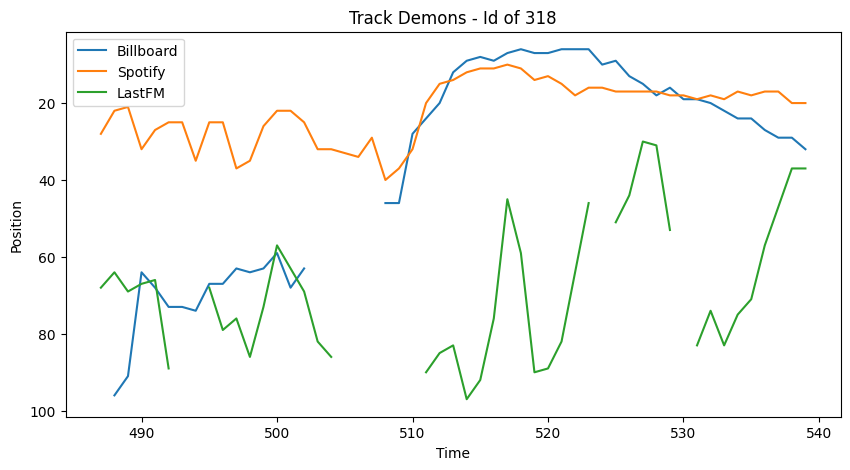

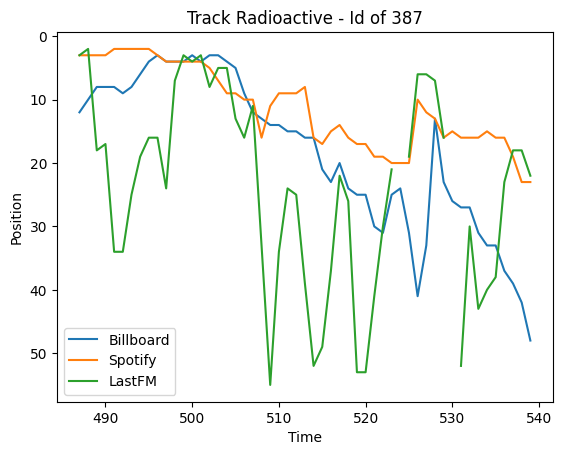

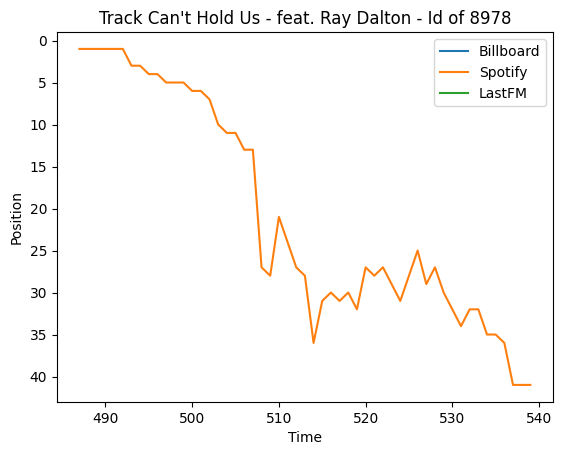

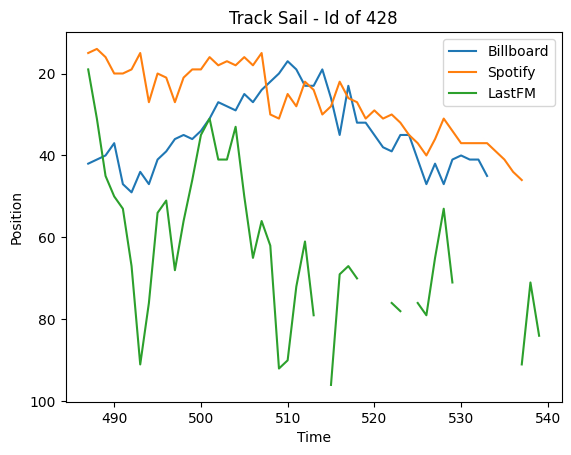

In [13]:
# In yearly data, identify which track_ids have 53 entries
track_id = df_year['track_id'].value_counts()
track_id = track_id[track_id == 53].index
track_id = track_id.tolist()
print('Track ids with 53 entries:', track_id)

# Get the tracks names
track_names = [convert_track_id_to_name(track) for track in track_id]
print('Track names with 53 entries:', track_names)

# Get the values on the columns position_billboard, position_spotify and position_lastfm for the track with 53 entries
df_year_53 = df_year[df_year['track_id'].isin(track_id)]
df_year_53 = df_year_53[['track_id','time_epoch' , 'position_billboard', 'position_spotify', 'position_lastfm']]

# Plot the evolution of the three positions for the track with 53 entries
plt.figure(figsize=(10, 5))
for track in track_id:
    df_year_single = df_year_53[df_year_53['track_id'] == track]
    plt.plot(df_year_single['time_epoch'], df_year_single['position_billboard'], label='Billboard')
    plt.plot(df_year_single['time_epoch'], df_year_single['position_spotify'], label='Spotify')
    plt.plot(df_year_single['time_epoch'], df_year_single['position_lastfm'], label='LastFM')
    plt.xlabel('Time')
    plt.ylabel('Position')
    plt.title(f'Track {convert_track_id_to_name(track)} - Id of {track}')
    plt.gca().invert_yaxis()
    plt.legend()
    plt.show()

### Billboard Top 100 Consecutive Weeks Per Track

In [14]:
# Create a list to store the results
billboard_top100_weeks = []

# Iterate over the track ids
for track_id in track_ids:
    # Get the track data
    df_year_single = df_year[df_year['track_id'] == track_id]
    # Sort by time_epoch to ensure chronological order
    df_year_single = df_year_single.sort_values('time_epoch')
    # Filter out rows without a position in the Billboard top 100
    df_year_single = df_year_single.dropna(subset=['position_billboard'])
    
    if df_year_single.empty:
        continue

    # Calculate the number of consecutive weeks
    weeks = 0
    max_consecutive_weeks = 0
    last_epoch = None
    starting_week_max = 0
    ending_week_max = 0
    starting_pos_max = 0
    ending_pos_max = 0

    for _, row in df_year_single.iterrows():
        current_epoch = row['time_epoch']
        if last_epoch is None or current_epoch - last_epoch == 1:
            # If consecutive, increment the counter
            weeks += 1
        else:
            # If not consecutive, reset the counter
            weeks = 1
        # Update the maximum consecutive weeks
        if weeks > max_consecutive_weeks:
            max_consecutive_weeks = weeks
            starting_week_max = current_epoch - weeks + 1
            ending_week_max = current_epoch
            starting_pos_max = df_year_single[df_year_single['time_epoch'] == starting_week_max]['position_billboard'].values[0]
            ending_pos_max = df_year_single[df_year_single['time_epoch'] == ending_week_max]['position_billboard'].values[0]
        last_epoch = current_epoch

    # Get the first and last positions of the track
    first_position = df_year_single['position_billboard'].iloc[0]
    last_position = df_year_single['position_billboard'].iloc[-1]

    # Save the results
    billboard_top100_weeks.append((track_id, first_position, last_position, max_consecutive_weeks, starting_week_max, ending_week_max, starting_pos_max, ending_pos_max))

# Sort the results by the number of consecutive weeks
billboard_top100_weeks = sorted(billboard_top100_weeks, key=lambda x: x[3], reverse=True)

# Print the results
print('Tracks with the highest number of consecutive weeks in the Billboard top 100:')
#for track_id, first_position, last_position, max_consecutive_weeks, starting_week_max, ending_week_max, starting_pos_max, ending_pos_max in billboard_top100_weeks:
#    if max_consecutive_weeks > 1:
#        print(f'Track: {convert_track_id_to_name(track_id)} of id {track_id} - First Position: {first_position} - Last Position: {last_position} - Max Consecutive Weeks: {max_consecutive_weeks} - Starting Week: {starting_week_max} - Ending Week: {ending_week_max} - Starting Position: {starting_pos_max} - Ending Position: {ending_pos_max}')

print('Tracks that did not start on the first week:')
for track_id, first_position, last_position, max_consecutive_weeks, starting_week_max, ending_week_max, starting_pos_max, ending_pos_max in billboard_top100_weeks:
    if starting_week_max != 487 and max_consecutive_weeks > 1:
        print(f'Track: {convert_track_id_to_name(track_id)} of id {track_id} - First Position: {first_position} - Last Position: {last_position} - Max Consecutive Weeks: {max_consecutive_weeks} - Starting Week: {starting_week_max} - Ending Week: {ending_week_max} - Starting Position: {starting_pos_max} - Ending Position: {ending_pos_max}')



Tracks with the highest number of consecutive weeks in the Billboard top 100:
Tracks that did not start on the first week:
Track: Blurred Lines of id 427 - First Position: 89.0 - Last Position: 48.0 - Max Consecutive Weeks: 47 - Starting Week: 488.0 - Ending Week: 534.0 - Starting Position: 89.0 - Ending Position: 48.0
Track: Counting Stars of id 215 - First Position: 32.0 - Last Position: 11.0 - Max Consecutive Weeks: 44 - Starting Week: 496.0 - Ending Week: 539.0 - Starting Position: 32.0 - Ending Position: 11.0
Track: Wake Me Up! of id 310 - First Position: 81.0 - Last Position: 30.0 - Max Consecutive Weeks: 43 - Starting Week: 497.0 - Ending Week: 539.0 - Starting Position: 81.0 - Ending Position: 30.0
Track: Safe And Sound of id 449 - First Position: 99.0 - Last Position: 44.0 - Max Consecutive Weeks: 43 - Starting Week: 489.0 - Ending Week: 531.0 - Starting Position: 99.0 - Ending Position: 44.0
Track: Royals of id 379 - First Position: 90.0 - Last Position: 42.0 - Max Consecutiv

### Last.fm Top 100 Consecutive Weeks Per Track

In [15]:
lastfm_top100_weeks = []

# Iterate over the track ids

for track_id in track_ids:
    # Get the track data
    df_year_single = df_year[df_year['track_id'] == track_id]
    # Sort by time_epoch to ensure chronological order
    df_year_single = df_year_single.sort_values('time_epoch')
    # Filter out rows without a position in the LastFM top 100
    df_year_single = df_year_single.dropna(subset=['position_lastfm'])
    
    if df_year_single.empty:
        continue

    # Calculate the number of consecutive weeks
    weeks = 0
    max_consecutive_weeks = 0
    last_epoch = None
    starting_week_max = 0
    ending_week_max = 0
    starting_pos_max = 0
    ending_pos_max = 0

    for _, row in df_year_single.iterrows():
        current_epoch = row['time_epoch']
        if last_epoch is None or current_epoch - last_epoch == 1:
            # If consecutive, increment the counter
            weeks += 1
        else:
            # If not consecutive, reset the counter
            weeks = 1
        # Update the maximum consecutive weeks
        if weeks > max_consecutive_weeks:
            max_consecutive_weeks = weeks
            starting_week_max = current_epoch - weeks + 1
            ending_week_max = current_epoch
            starting_pos_max = df_year_single[df_year_single['time_epoch'] == starting_week_max]['position_lastfm'].values[0]
            ending_pos_max = df_year_single[df_year_single['time_epoch'] == ending_week_max]['position_lastfm'].values[0]
        last_epoch = current_epoch

    # Get the first and last positions of the track
    first_position = df_year_single['position_lastfm'].iloc[0]
    last_position = df_year_single['position_lastfm'].iloc[-1]

    # Save the results
    lastfm_top100_weeks.append((track_id, first_position, last_position, max_consecutive_weeks, starting_week_max, ending_week_max, starting_pos_max, ending_pos_max))

# Sort the results by the number of consecutive weeks
lastfm_top100_weeks = sorted(lastfm_top100_weeks, key=lambda x: x[3], reverse=True)

# Print the results
print('Tracks with the highest number of consecutive weeks in the LastFM top 100:')
#for track_id, first_position, last_position, max_consecutive_weeks, starting_week_max, ending_week_max, starting_pos_max, ending_pos_max in lastfm_top100_weeks:
#    if max_consecutive_weeks > 1:
#        print(f'Track: {convert_track_id_to_name(track_id)} of id {track_id} - First Position: {first_position} - Last Position: {last_position} - Max Consecutive Weeks: {max_consecutive_weeks} - Starting Week: {starting_week_max} - Ending Week: {ending_week_max} - Starting Position: {starting_pos_max} - Ending Position: {ending_pos_max}')

print('Tracks that did not start on the first week:')

for track_id, first_position, last_position, max_consecutive_weeks, starting_week_max, ending_week_max, starting_pos_max, ending_pos_max in lastfm_top100_weeks:
    if starting_week_max != 487 and max_consecutive_weeks > 1:
        print(f'Track: {convert_track_id_to_name(track_id)} of id {track_id} - First Position: {first_position} - Last Position: {last_position} - Max Consecutive Weeks: {max_consecutive_weeks} - Starting Week: {starting_week_max} - Ending Week: {ending_week_max} - Starting Position: {starting_pos_max} - Ending Position: {ending_pos_max}')

Tracks with the highest number of consecutive weeks in the LastFM top 100:
Tracks that did not start on the first week:
Track: Get Lucky (feat. Pharrell Williams) of id 7577 - First Position: 6.0 - Last Position: 48.0 - Max Consecutive Weeks: 35 - Starting Week: 489.0 - Ending Week: 523.0 - Starting Position: 6.0 - Ending Position: 26.0
Track: Black Skinhead of id 718 - First Position: 2.0 - Last Position: 50.0 - Max Consecutive Weeks: 31 - Starting Week: 493.0 - Ending Week: 523.0 - Starting Position: 2.0 - Ending Position: 30.0
Track: Safe And Sound of id 449 - First Position: 76.0 - Last Position: 28.0 - Max Consecutive Weeks: 30 - Starting Week: 494.0 - Ending Week: 523.0 - Starting Position: 94.0 - Ending Position: 31.0
Track: Sweater Weather of id 450 - First Position: 43.0 - Last Position: 30.0 - Max Consecutive Weeks: 30 - Starting Week: 494.0 - Ending Week: 523.0 - Starting Position: 98.0 - Ending Position: 10.0
Track: Royals of id 379 - First Position: 87.0 - Last Position: 5

### Spotify Top 100 Consecutive Weeks Per Track

In [16]:
spotify_top100_weeks = []

# Iterate over the track ids

for track_id in track_ids:
    # Get the track data
    df_year_single = df_year[df_year['track_id'] == track_id]
    # Sort by time_epoch to ensure chronological order
    df_year_single = df_year_single.sort_values('time_epoch')
    # Filter out rows without a position in the Spotify top 100
    df_year_single = df_year_single.dropna(subset=['position_spotify'])
    
    if df_year_single.empty:
        continue

    # Calculate the number of consecutive weeks
    weeks = 0
    max_consecutive_weeks = 0
    last_epoch = None
    starting_week_max = 0
    ending_week_max = 0
    starting_pos_max = 0
    ending_pos_max = 0

    for _, row in df_year_single.iterrows():
        current_epoch = row['time_epoch']
        if last_epoch is None or current_epoch - last_epoch == 1:
            # If consecutive, increment the counter
            weeks += 1
        else:
            # If not consecutive, reset the counter
            weeks = 1
        # Update the maximum consecutive weeks
        if weeks > max_consecutive_weeks:
            max_consecutive_weeks = weeks
            starting_week_max = current_epoch - weeks + 1
            ending_week_max = current_epoch
            starting_pos_max = df_year_single[df_year_single['time_epoch'] == starting_week_max]['position_spotify'].values[0]
            ending_pos_max = df_year_single[df_year_single['time_epoch'] == ending_week_max]['position_spotify'].values[0]
        last_epoch = current_epoch

    # Get the first and last positions of the track
    first_position = df_year_single['position_spotify'].iloc[0]
    last_position = df_year_single['position_spotify'].iloc[-1]

    # Save the results
    spotify_top100_weeks.append((track_id, first_position, last_position, max_consecutive_weeks, starting_week_max, ending_week_max, starting_pos_max, ending_pos_max))

# Sort the results by the number of consecutive weeks
spotify_top100_weeks = sorted(spotify_top100_weeks, key=lambda x: x[3], reverse=True)

# Print the results
print('Tracks with the highest number of consecutive weeks in the Spotify top 100:')
#for track_id, first_position, last_position, max_consecutive_weeks, starting_week_max, ending_week_max, starting_pos_max, ending_pos_max in spotify_top100_weeks:
#    if max_consecutive_weeks > 1:
#        print(f'Track: {convert_track_id_to_name(track_id)} of id {track_id} - First Position: {first_position} - Last Position: {last_position} - Max Consecutive Weeks: {max_consecutive_weeks} - Starting Week: {starting_week_max} - Ending Week: {ending_week_max} - Starting Position: {starting_pos_max} - Ending Position: {ending_pos_max}')

print('Tracks that did not start on the first week:')
for track_id, first_position, last_position, max_consecutive_weeks, starting_week_max, ending_week_max, starting_pos_max, ending_pos_max in spotify_top100_weeks:
    if starting_week_max != 487 and max_consecutive_weeks > 1:
        print(f'Track: {convert_track_id_to_name(track_id)} of id {track_id} - First Position: {first_position} - Last Position: {last_position} - Max Consecutive Weeks: {max_consecutive_weeks} - Starting Week: {starting_week_max} - Ending Week: {ending_week_max} - Starting Position: {starting_pos_max} - Ending Position: {ending_pos_max}')

Tracks with the highest number of consecutive weeks in the Spotify top 100:
Tracks that did not start on the first week:
Track: Blurred Lines of id 7615 - First Position: 29.0 - Last Position: 49.0 - Max Consecutive Weeks: 47 - Starting Week: 489.0 - Ending Week: 535.0 - Starting Position: 29.0 - Ending Position: 49.0
Track: Royals of id 379 - First Position: 44.0 - Last Position: 24.0 - Max Consecutive Weeks: 44 - Starting Week: 496.0 - Ending Week: 539.0 - Starting Position: 44.0 - Ending Position: 24.0
Track: Wake Me Up of id 7709 - First Position: 33.0 - Last Position: 33.0 - Max Consecutive Weeks: 44 - Starting Week: 496.0 - Ending Week: 539.0 - Starting Position: 33.0 - Ending Position: 33.0
Track: Counting Stars of id 215 - First Position: 46.0 - Last Position: 16.0 - Max Consecutive Weeks: 41 - Starting Week: 499.0 - Ending Week: 539.0 - Starting Position: 46.0 - Ending Position: 16.0
Track: Pompeii of id 268 - First Position: 48.0 - Last Position: 8.0 - Max Consecutive Weeks: 